### Dataset contains columns Category and Message. Category column contains "spam" and "ham" values in it, meaning

### spam - unwanted messages
### ham - regular messages

### It will be shown that part of ham messages contains obscene language and in some situations it would be considered spam, but in the context of the project that I made these messages were not considered spam because they were not marketing emails or ads.

### The main steps of this project are creating a recurrent neural network, trying to improve results in different ways, analysing the learning process and the impact of improvements or the lack of it.

### Imports block

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from nltk import download
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from collections import Counter, defaultdict 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from gensim.models import Word2Vec, KeyedVectors
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from scipy import stats
from textblob import TextBlob

### Explore and prepare the data

#### Load the data

In [8]:
df = pd.read_csv ('/Users/sofiialukashevych/Desktop/University Masters KNU/masters 2nd year/SPAM text message 20170820 - Data.csv')

In [9]:
display(df)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [10]:
category_counts = df['Category'].value_counts()

ham_count = category_counts.get('ham', 0)
spam_count = category_counts.get('spam', 0)

print('Ham count:', ham_count)
print('Spam count:', spam_count)

Ham count: 4825
Spam count: 747


/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


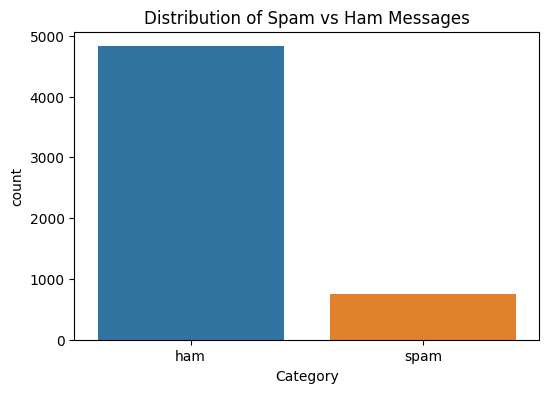

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Category', data=df)
plt.title('Distribution of Spam vs Ham Messages')
plt.show()

#### Define a function to plot most common words

In [13]:
def plot_most_common_words(messages, title, num_words=20):
    words = ' '.join(messages).split()
    filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]
    most_common_words = Counter(filtered_words).most_common(num_words)
    common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frequency', y='Word', data=common_words_df)
    plt.title(title)
    plt.show()

In [14]:
spam_messages = df[df['Category'] == 'spam']['Message']
ham_messages = df[df['Category'] == 'ham']['Message']

#### Plot most common words

/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


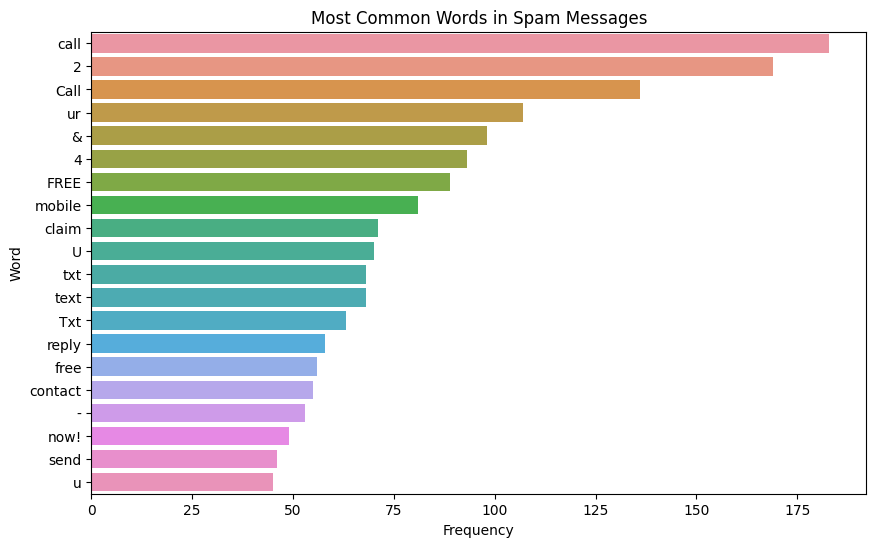

In [15]:
plot_most_common_words(spam_messages, 'Most Common Words in Spam Messages')

/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


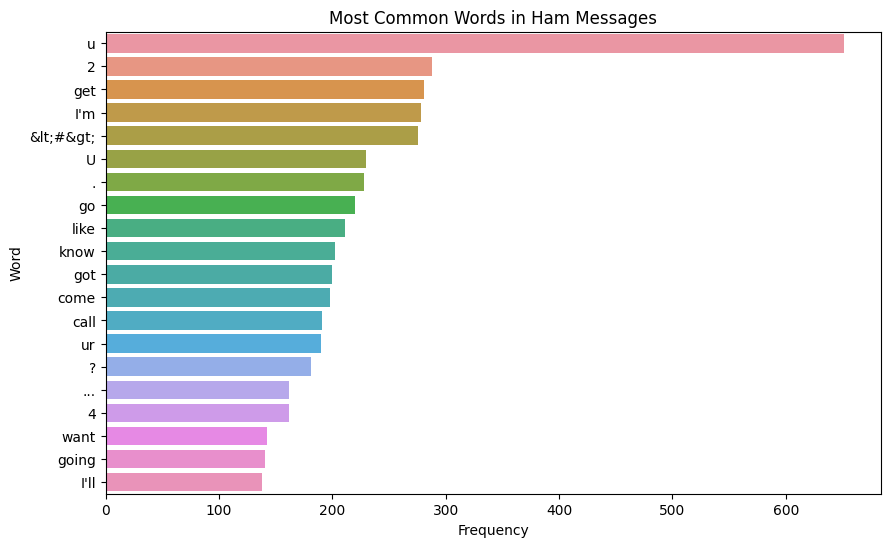

In [16]:
plot_most_common_words(ham_messages, 'Most Common Words in Ham Messages')

#### Define a function to create word clouds

In [18]:
def create_wordcloud(messages, title):
    text = ' '.join(messages)
    wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color='white', max_words=100).generate(text)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

#### Plot word clouds

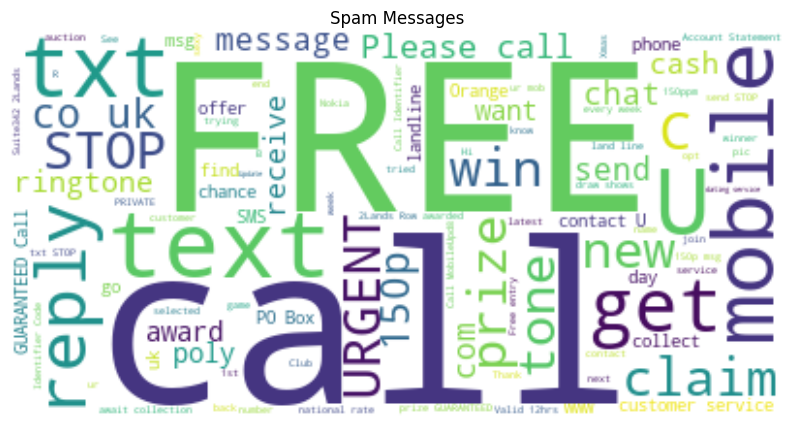

In [19]:
create_wordcloud(spam_messages, 'Spam Messages')

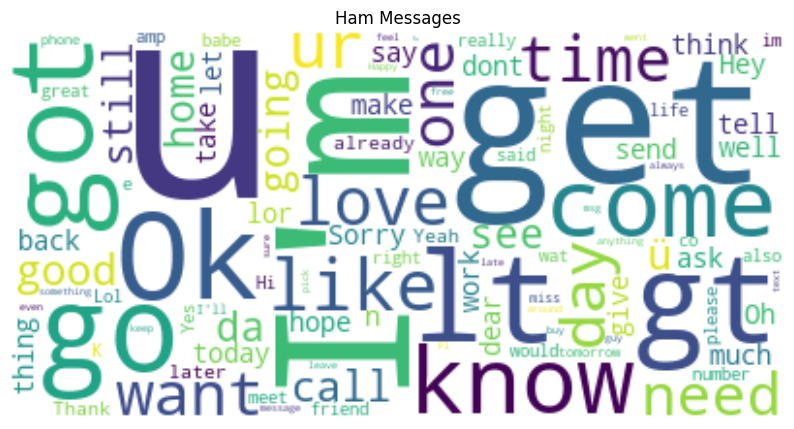

In [20]:
create_wordcloud(ham_messages, 'Ham Messages')

### We can see that spam messages are filled with trigger words and call-to-action words, like 'free', 'call', 'win', 'claim'.
### Ham messages have more casual words, like 'u', 'know', 'ok', 'get', 'I'm'.

### We can also look at the correlation between message's length and it being a spam message.

In [21]:
data = df

#### Convert categories to numerical values for correlation analysis

In [22]:
data['Category_num'] = data['Category'].apply(lambda x: 1 if x == 'spam' else 0)

#### Calculate the length of each message

In [23]:
data['Message_length'] = data['Message'].apply(len)

#### Correlation between the length and being spam

In [24]:
correlation, p_value = stats.pearsonr(data['Message_length'], data['Category_num'])
print(f'Correlation between message length and spam: {correlation}, p-value: {p_value}')

Correlation between message length and spam: 0.37835894846838825, p-value: 3.8259526484801435e-189


#### Correlation Coefficient indicates a moderate positive correlation between the length of the message and whether it is spam. 
#### So longer messages are more likely to be spam messages.

#### The p-value is extremely small meaning that the correlation is statistically significant. 
#### This means that the correlation that we got is very unlikely to be this way due to a random chance.

### Sentiment Analysis

In [25]:
data['Sentiment'] = data['Message'].apply(lambda x: TextBlob(x).sentiment.polarity)

#### Summary statistics of sentiment

In [26]:
sentiment_summary = data['Sentiment'].describe()
print(sentiment_summary)

count    5572.000000
mean        0.126302
std         0.292564
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.308333
max         1.000000
Name: Sentiment, dtype: float64


#### Plot sentiment distribution

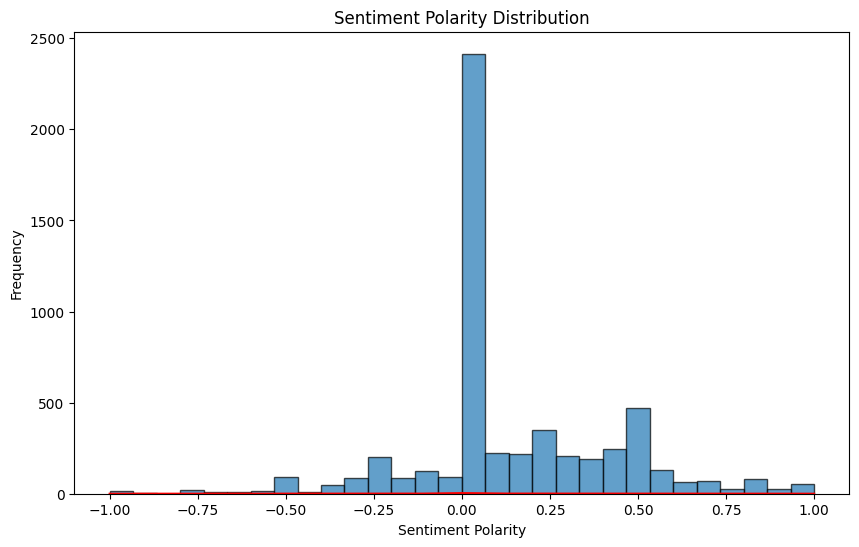

In [32]:
plt.figure(figsize=(10, 6))
plt.hist(data['Sentiment'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')

sentiment_values = data['Sentiment'].dropna().values
density = stats.gaussian_kde(sentiment_values)
x_vals = np.linspace(min(sentiment_values), max(sentiment_values), 1000)
plt.plot(x_vals, density(x_vals), color='red')

plt.show()

#### We can say that messages tend to have a slightly positive sentiment (mean = 0.126302).
#### Most of the messages are centered around a sentiment polarity of 0.
#### Overall we can see that the majority of messages are neutral with a slight positive connotation.
#### This is understandable considering the context of our dataset.
#### There are also some negative sentiment and positive sentiment outliers in the dataset.
#### The project was more centered around trying to classify messages so we won't dive deeper into the sintiment analysis and will stop here.

### Encode categorical data where spam - 1, ham - 0.

In [5]:
category_mapping = {'ham': 0, 'spam': 1}

In [6]:
df['Category'] = df['Category'].map(category_mapping)

In [56]:
display(df)

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [7]:
category_counts = df['Category'].value_counts()

ham_count = category_counts.get(0, 0)
spam_count = category_counts.get(1, 0)

print('Ham count:', ham_count)
print('Spam count:', spam_count)

Ham count: 4825
Spam count: 747


#### We will try to remove words that don't have much (and ounctuation).
#### Lets also make each message an array.

In [8]:
for pkg in ['omw-1.4', 'punkt', 'stopwords', 'wordnet']:
    download(pkg)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sofiialukashevych/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sofiialukashevych/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sofiialukashevych/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sofiialukashevych/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words('english'))

#### Write a function that tokenizes words, detects punctuation, and lemmatizes (reduces to the root) words.

In [10]:
def preprocess_text(tokenizer, lemmatizer, stop_words, punctuation, text): 
    tokens = tokenizer(text.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return [token for token in lemmas if token not in stop_words and token not in punctuation]

In [11]:
df['Message_modified'] = df['Message'].apply(
    lambda x: preprocess_text(word_tokenize, lemmatizer, stop_words, punctuation, x)
)

In [62]:
display(df)

,Category,Message,Message_modified
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, .., available, bugi..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar, ..., joking, wif, u, oni, ...]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, ..., u, c, already, ..."
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, n't, think, go, usf, life, around, though]"
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,"[2nd, time, tried, 2, contact, u., u, £750, po..."
5568,0,Will ü b going to esplanade fr home?,"[ü, b, going, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...","[pity, wa, mood, ..., suggestion]"
5570,0,The guy did some bitching but I acted like i'd...,"[guy, bitching, acted, like, 'd, interested, b..."


#### Split data into test and train parts.

In [12]:
n_ham = len(df[df['Category'] == 0])
n_ham

4825

In [13]:
n_spam = len(df[df['Category'] == 1])
n_spam

747

#### Let's fix the imbalance between spam and ham using resampling. An attempt to use the class weights approach was unsuccessful due to technical issues with my computer, and started showing errors related to the shell. The undersampling option was chosen, it is worth noting that this is a very rough option for correcting such a situation, ideally it is better to use the class weights approach. But let's see what such a choice will lead to.

In [14]:
n_spam_df = df[df['Category'] == 1]
n_ham_df = df[df['Category'] == 0].sample(n=spam_count, random_state=42)


undersampled_df = pd.concat([n_spam_df, n_ham_df])

undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

undersampled_category_counts = undersampled_df['Category'].value_counts()
undersampled_ham_count = undersampled_category_counts.get(0, 0)
undersampled_spam_count = undersampled_category_counts.get(1, 0)

print('Undersampled Ham count:', undersampled_ham_count)
print('Undersampled Spam count:', undersampled_spam_count)

Undersampled Ham count: 747
Undersampled Spam count: 747


In [119]:
undersampled_df

,Category,Message,Message_modified
0,0,The evo. I just had to download flash. Jealous?,"[evo, download, flash, jealous]"
1,0,Hi Dear Call me its urgnt. I don't know whats ...,"[hi, dear, call, urgnt, n't, know, whats, prob..."
2,0,Full heat pa:-) i have applyed oil pa.,"[full, heat, pa, applyed, oil, pa]"
3,0,Gokila is talking with you aha:),"[gokila, talking, aha]"
4,0,"Dude u knw also telugu..thts gud..k, gud nyt..","[dude, u, knw, also, telugu, .., thts, gud, ....."
...,...,...,...
1489,0,Ya srsly better than yi tho,"[ya, srsly, better, yi, tho]"
1490,0,I'm coming home 4 dinner.,"['m, coming, home, 4, dinner]"
1491,0,"I'm there and I can see you, but you can't see...","['m, see, ca, n't, see, maybe, reboot, ym, see..."
1492,0,Sent me ur email id soon,"[sent, ur, email, id, soon]"


In [15]:
n_ham_new = len(undersampled_df[undersampled_df['Category'] == 0])
n_ham_new

747

In [16]:
n_spam_new = len(undersampled_df[undersampled_df['Category'] == 1])
n_spam_new

747

In [17]:
np.random.seed(0)
n = n_ham_new
n_test = n // 10
n_test

74

In [18]:
test_ham = np.random.choice(
    np.arange(0, n_ham_new), size=(n_test // 2), replace=False
)

In [19]:
test_spam = np.random.choice(
    n_ham_new + np.arange(0, n_spam_new), size=(n_test // 2), replace=False
)

In [126]:
undersampled_df.iloc[test_ham][['Message_modified', 'Category']]

,Message_modified,Category
258,"[tomorrow, onwards, eve, 6, 3, work]",0
521,"[wylie, update, weed, dealer, carlos, went, fr...",0
14,"[congrats, 1, year, special, cinema, pas, 2, c...",1
31,"[wo, n't, believe, 's, true, 's, incredible, t...",1
505,"[collect, valentine, 's, weekend, paris, inc, ...",1
79,"[dear, voucher, holder, claim, week, offer, pc...",1
382,"[g, say, never, answer, text, confirm/deny]",0
75,"[want, new, nokia, 3510i, colour, phone, deliv...",1
471,"[came, look, flat, seems, ok, 50, away, alot, ...",0
27,"[r, giving, second, chance, rahul, dengra]",0


In [127]:
undersampled_df.iloc[test_spam][['Message_modified', 'Category']]

,Message_modified,Category
1447,"[private, 2004, account, statement, 078498, 7,...",1
756,"[cd, 4u, congratulation, ur, awarded, £500, cd...",1
1126,"[except, chick, huge, boob]",0
801,"[monthly, password, wap, mobsi.com, 391784., u...",1
1438,"[sunshine, quiz, wkly, q, win, top, sony, dvd,...",1
1115,"[ok, lor, ...]",0
1483,"[fantasy, football, back, tv, go, sky, gamesta...",1
938,"[get, 3, lion, england, tone, reply, lionm, 4,...",1
1187,"[forced, eat, slice, 'm, really, hungry, tho, ...",0
974,"[opinion, 1., 2., jada, 3., kusruthi, 4., lova...",0


In [20]:
np.random.seed(12345)

test = np.append(test_ham, test_spam)
np.random.shuffle(test)
test

array([ 505,  951,  400,    8,  938,   14, 1331,  862, 1443,  974,  250,
        337, 1424,  157,  603,  772, 1453,  497, 1360, 1300,   27,  338,
       1224, 1310,  215, 1134, 1411,  631,  382, 1369,  283, 1172, 1115,
        583,  113, 1447,  753,  801,  471, 1238, 1187,  873, 1232, 1279,
        718,   79,   31,  939,  258,  966, 1386,   55,  568,  655, 1291,
        230, 1126, 1483,   75,  756,  385,  457,  641,  522,  367,   40,
        829, 1308, 1406,  669, 1438,  702,  521,  333])

In [21]:
df_train = undersampled_df.drop(index=test, axis=0).sample(frac=1)
df_test = undersampled_df.iloc[test]

In [130]:
df_test.shape

(74, 3)

In [131]:
df_test[['Message_modified', 'Category']].head()

,Message_modified,Category
505,"[collect, valentine, 's, weekend, paris, inc, ...",1
951,"[boltblue, tone, 150p, reply, poly, mono, eg, ...",1
400,"[haha, awesome, might, need, take, doin, tonight]",0
8,"[sppok, ur, mob, halloween, collection, nokia,...",1
938,"[get, 3, lion, england, tone, reply, lionm, 4,...",1


In [132]:
df_train.shape

(1420, 3)

In [133]:
df_train[['Message_modified', 'Category']].head()

,Message_modified,Category
1077,"[ur, awarded, city, break, could, win, £200, s...",1
751,"[jus, chillaxin]",0
278,"[lmao, nice, 1]",0
709,"[romantic, paris, 2, night, 2, flight, £79, bo...",1
1152,"[look, like, found, something, smoke, great, job]",0


створимо словник

In [22]:
def flat_nested(y):
    flatten = []
    for x in y:
        if isinstance(x, list):
            flatten.extend(x)
        else:
            flatten.append(x)
    return flatten

In [23]:
vocabular = set(flat_nested(df_train['Message_modified'].tolist()))

#### Let's look at frequently "used" words in the dictionary to understand its quality.

In [24]:
cnt_vocab = Counter(flat_nested(df_train['Message_modified'].tolist()))

In [136]:
cnt_vocab.most_common(50)

[('call', 379),
 ('u', 277),
 ('free', 215),
 ('2', 203),
 ('ur', 168),
 ('...', 168),
 ('txt', 153),
 ('text', 143),
 ("'s", 138),
 ('mobile', 133),
 ('get', 128),
 ('4', 126),
 ('stop', 120),
 ('..', 115),
 ('reply', 105),
 ('claim', 105),
 ('c', 95),
 ('new', 86),
 ('prize', 85),
 ('send', 84),
 ('service', 70),
 ('tone', 68),
 ('go', 67),
 ("n't", 66),
 ('day', 64),
 ("'m", 64),
 ('phone', 64),
 ('nokia', 64),
 ('week', 63),
 ('cash', 60),
 ('please', 60),
 ('want', 60),
 ('win', 59),
 ('urgent', 58),
 ('message', 56),
 ('know', 55),
 ('ha', 54),
 ('contact', 53),
 ('min', 53),
 ('lt', 52),
 ('time', 51),
 ('gt', 51),
 ('today', 50),
 ('customer', 50),
 ('r', 49),
 ('wa', 49),
 ('guaranteed', 46),
 ('number', 46),
 ('good', 45),
 ('per', 45)]

In [137]:
cnt_vocab.most_common()[-50:-1]

[('dp', 1),
 ('bcm', 1),
 ('8027', 1),
 ('tarot', 1),
 ('85555', 1),
 ('olympics', 1),
 ('09090900040', 1),
 ('extreme', 1),
 ('dirty', 1),
 ('total', 1),
 ('privacy', 1),
 ('sic', 1),
 ('60p', 1),
 ('24/7mp', 1),
 ('0870753331018+', 1),
 ('hottest', 1),
 ('wanting', 1),
 ('07801543489', 1),
 ('no:83355', 1),
 ('tc-llc', 1),
 ('ny-usa', 1),
 ('150p/mt', 1),
 ('msgrcvd18+', 1),
 ('n-gage', 1),
 ('deck', 1),
 ('www.cnupdates.com/newsletter', 1),
 ('32000', 1),
 ('legitimat', 1),
 ('efreefone', 1),
 ('outbid', 1),
 ('simonwatson5120', 1),
 ('shinco', 1),
 ('plyr', 1),
 ('ac/smsrewards', 1),
 ('notification', 1),
 ('install', 1),
 ('browse', 1),
 ('artist', 1),
 ('wined', 1),
 ('dined', 1),
 ('www.gamb.tv', 1),
 ('09061701939.', 1),
 ('s89', 1),
 ('messages-text', 1),
 ('web2mobile', 1),
 ('txt250.com', 1),
 ('1.50p/wk', 1),
 ('box139', 1),
 ('la32wu', 1)]

#### We can see that we have separate letters, dots etc.
#### We have to make a cleaner version of the dictionary.

In [25]:
threshold_count = 1
threshold_len = 2
cleaned_vocabular = list()
for token, count in cnt_vocab.items():
    if count > threshold_count and len(token) > threshold_len:
        cond_digit = not any(c.isdigit() for c in token)
        cond_punct = token[0] not in punctuation
        
        if cond_digit and cond_punct:
            cleaned_vocabular.append(token)

In [26]:
def sequence_cleaner(s, voc):
    res = [sj for sj in s if sj in voc]
    return res

df_train['Message_filtered'] = df_train['Message_modified'].apply(lambda u: sequence_cleaner(u, cleaned_vocabular))
df_test['Message_filtered'] = df_test['Message_modified'].apply(lambda u: sequence_cleaner(u, cleaned_vocabular))

/var/folders/4b/b3hx73cj4fzcm29xwvlsn2j80000gn/T/ipykernel_78591/3951361505.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Message_filtered'] = df_test['Message_modified'].apply(lambda u: sequence_cleaner(u, cleaned_vocabular))


In [247]:
df_train['Message_filtered'][df_train['Message_filtered'].apply(lambda u: len(u)) == 0]

1126    []
Name: Message_filtered, dtype: object

In [249]:
df_train[['Message_modified', 'Message_filtered', 'Category']].head()

,Message_modified,Message_filtered,Category
0,"[ur, awarded, city, break, could, win, £200, s...","[awarded, city, break, could, win, summer, sho...",1
1,"[jus, chillaxin]",[jus],0
2,"[lmao, nice, 1]","[lmao, nice]",0
3,"[romantic, paris, 2, night, 2, flight, £79, bo...","[night, flight, book, next, year, call, apply]",1
4,"[look, like, found, something, smoke, great, job]","[look, like, found, something, smoke, great, job]",0


In [141]:
df_test[['Message_modified', 'Message_filtered', 'Category']].head()

,Message_modified,Message_filtered,Category
505,"[collect, valentine, 's, weekend, paris, inc, ...","[collect, valentine, weekend, inc, flight, hot...",1
951,"[boltblue, tone, 150p, reply, poly, mono, eg, ...","[tone, reply, poly, mono, yeah, come, stop, to...",1
400,"[haha, awesome, might, need, take, doin, tonight]","[haha, awesome, might, need, take, doin, tonight]",0
8,"[sppok, ur, mob, halloween, collection, nokia,...","[mob, halloween, collection, nokia, logo, pic,...",1
938,"[get, 3, lion, england, tone, reply, lionm, 4,...","[get, england, tone, reply, mono, poly, www.ri...",1


#### The situation has improved.
#### It should be noted that the messages themselves were written in a casual style, not a professional one. therefore, some of the abbreviations characteristic of the native speakers of the language could remain. It is also worth clarifying that the proposed approach to converting sentences into tokens is somewhat rough, because it cuts connections that are partially based on the same particles (was, dont, does, etc). But the main meaning of the sentence can be conveyed even in this case.

### Let's build a recurrent neural network with its own word embedding layer.

In [27]:
torch.manual_seed(12345)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Поки спробуємо на cpu, може 10-ти штук вистачить.

In [29]:
#a copy of the clean dictionary in order not to remake it in case of possible unsuccessful changes in the future
vocabulary_main = cleaned_vocabular.copy()
vocabulary_main.append(' ')

WORD_TO_IDX = {WORD: IDX for IDX, WORD in enumerate(vocabulary_main)}

def vectorize(s, word_map):
    sequence_lengths = list(map(len, s))
    max_length = max(sequence_lengths)
    
    s_idx = np.zeros([len(s), max_length]) + word_map.get('', 0)

    for j in range(len(s)):
        line_idx = [word_map[w] for w in s[j] if w in word_map]
        s_idx[j, :len(line_idx)] = line_idx

    return s_idx, sequence_lengths

In [30]:
class BaseRNN(nn.Module):
    #initialization method for the BaseRNN class
    def __init__(self, vocab_size, embedding_size, hidden_size):
        #call the parent class constructor
        super(self.__class__, self).__init__()
        #create an embedding layer with the specified vocabulary size and embedding size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        #create an RNN layer with input size (embedding size) and hidden state size
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)
        #create a linear layer with input size (hidden state size) and output size 1
        self.linear = nn.Linear(hidden_size, 1)  
        #create a Sigmoid activation function
        self.sigmoid = nn.Sigmoid()
        
    #forward method that defines the computations during the forward pass    
    def forward(self, x, sequences_lengths):
        #pass the text sequence
        embedding = self.embedding(x)
        #pack the embedded sequence based on the specified sequence lengths
        pack = torch.nn.utils.rnn.pack_padded_sequence(
            embedding, sequences_lengths, 
            batch_first=True, enforce_sorted=False
        )
        #pass the packed sequence through the RNN layer (engage the recurrent component)
        all_hidden_states, hidden = self.rnn(pack)
        #take the data from the RNN component to the linear layer
        from_linear = self.linear(hidden)
        #message classification prediction
        output = self.sigmoid(from_linear)
        return output


In [31]:
#initialize the model
model = BaseRNN(
    vocab_size=len(vocabulary_main), embedding_size=500, hidden_size=200
)
model.to(device)

BaseRNN(
  (embedding): Embedding(1416, 500)
  (rnn): RNN(500, 200, batch_first=True)
  (linear): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [32]:
epoch_loss_values = []
step_loss_values = []

In [33]:
#loss function
loss_function = nn.BCELoss()
#ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [34]:
batch_size = 50
n_epochs = 50
n_train = df_train.shape[0]
n_iters = n_train // batch_size

In [35]:
n_tab = str(len(str(n_epochs)))

In [36]:
#loop through epochs
for epoch in range(n_epochs):
    #initialize the sum of losses for each epoch
    epoch_loss = 0 
    
    #create a copy of the training dataset, shuffle it, and reset the index
    df_train_c = df_train.copy().sample(n_train).reset_index(drop=True)
    
    #loop through iterations within the epoch
    for step in range(n_iters):
        
        #"Zero" the gradients to prepare for the new iteration
        optimizer.zero_grad()
        #compute indixes for the current batch in the training data
        idx = np.arange(0, batch_size, 1) + batch_size * step
        current_batch = df_train_c.iloc[idx]

        #vectorize the messages in the current batch
        #get the sequence lengths
        batch_idx, seq_lengths = vectorize(current_batch['Message_filtered'].tolist(), WORD_TO_IDX)
        if any(length <= 0 for length in seq_lengths):
            continue
        seq_lengths = np.array(seq_lengths)
        #convert the batch indices to a PyTorch tensor and move to the device
        batch_idx = torch.tensor(batch_idx, dtype=torch.int64).to(device)

        #get true labels for the current batch and convert to a PyTorch tensor
        y_true = current_batch['Category'].tolist() 
        y_true = torch.tensor(y_true, dtype=torch.float).to(device)

        #calculate predictions
        y_pred = model(batch_idx, seq_lengths)
        
        #compute the loss between predicted and true labels
        loss = loss_function(y_pred.squeeze(), y_true)
        
        #add the loss value for the current step to the list
        step_loss_values.append(loss)
        
        #accumulate losses for the epoch
        epoch_loss += loss.item() / n_iters
        #compute gradients and update model parameters
        loss.backward()
        optimizer.step()
    
    epoch_loss_values.append(epoch_loss)
    
    #print the epoch number and total loss for the epoch
    print(('epoch {:' + n_tab + '}: epoch_loss: {}').format(epoch+1, epoch_loss))


epoch  1: epoch_loss: 0.23434042770947727
epoch  2: epoch_loss: 0.1099913114947932
epoch  3: epoch_loss: 0.07013509528977531
epoch  4: epoch_loss: 0.027429279804761918
epoch  5: epoch_loss: 0.024663378850423863
epoch  6: epoch_loss: 0.012508450707952893
epoch  7: epoch_loss: 0.02812455581235034
epoch  8: epoch_loss: 0.034070822676377635
epoch  9: epoch_loss: 0.03130581969993987
epoch 10: epoch_loss: 0.01475262289334621
epoch 11: epoch_loss: 0.00781803548202983
epoch 12: epoch_loss: 0.005799249238667211
epoch 13: epoch_loss: 0.0030353473100279056
epoch 14: epoch_loss: 0.004542175077533882
epoch 15: epoch_loss: 0.000738083353748412
epoch 16: epoch_loss: 0.0008549904076582088
epoch 17: epoch_loss: 0.00048250326134231206
epoch 18: epoch_loss: 0.00040634994885684647
epoch 19: epoch_loss: 0.0007544440450146795
epoch 20: epoch_loss: 0.0005649714403261896
epoch 21: epoch_loss: 0.0003774994708822175
epoch 22: epoch_loss: 0.0002792663963191444
epoch 23: epoch_loss: 0.0001317840485301401
epoch 24

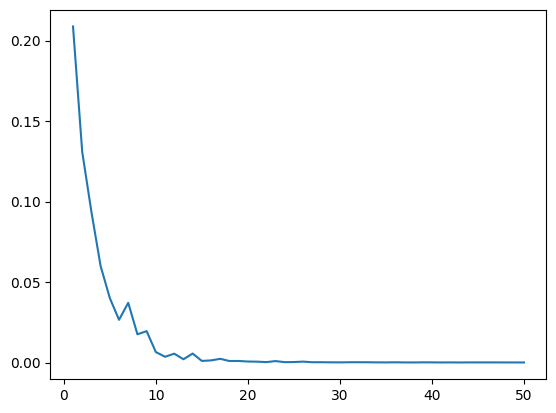

In [188]:
plt.plot(np.arange(1, n_epochs + 1), epoch_loss_values)
plt.show()

#### We can see a rapid decline in loss during the initial epochs, meaning the model is effectively learning from the data during the early training phase.

#### The final loss value is close to zero. This indicates that the model is performing well on the training data.

#### But we should remember that this also can indicate that the model is fitting too closely to the training data and we may have an overfitting.

In [37]:
#function to generate indexes that point to the limits of parts 
def index_marks(nrows, chunk_size):
    #generate ranges of indexes
    return range(1 * chunk_size, (nrows // chunk_size + 1) * chunk_size, chunk_size)

In [38]:
#function to split a DataFrame into chunks based on the specified chunk size
def split(df, chunk_size):
    #generate indixes
    indices = index_marks(df.shape[0], chunk_size)
    #split the DataFrame using generated indixes
    s = np.split(df, indices)
    #remove the last empty chunk (if it exists)
    if s[-1].empty:
        return s[:-1]
    return s

In [42]:
#function for making predictions using the model
def make_predictions(model, df_test, batch_size, threshold, prints_b=True): 
    #counter for printing predictions
    n_prints = 0
    #lists for storing true labels and predictions
    predictions = []
    true_labels = []
    #splitting the test data into mini-batches
    test_batches = split(df_test, batch_size)
    
    #iterating over mini-batches of test data
    for batch in test_batches:
        #vectorizing the messages in the mini-batch
        batch_ix, seq_lengths = vectorize(batch['Message_filtered'].tolist(), WORD_TO_IDX)
        if any(length <= 0 for length in seq_lengths):
            continue
        seq_lengths = np.array(seq_lengths)
        #converting to tensor mini-batches
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

        #getting the true categories spam(1)/ham(0) for the mini-batch
        y_true = batch['Category'].tolist()

        #making predictions
        y_pred = model(batch_ix, seq_lengths).cpu().detach().squeeze().numpy()
        y_pred = [int(pred.item() > threshold) for pred in y_pred]
        
        #adding true labels and predictions to the corresponding lists
        predictions.extend(y_pred)
        true_labels.extend(y_true)
        
        #printing predictions and reviews
        if prints_b:
            for true, pred, document in zip(y_true, y_pred, batch['Message']):
                if true == 1.0 and n_prints < 10:
                    print("prediction: {}".format(pred))
                    print("truth: {}".format(true))
                    print("message contains: {}".format(document))
                    print("\n" + "/////////////////////////////" + "\n")
                    n_prints += 1
        
    return true_labels, predictions


In [43]:
true_labels, predictions = make_predictions(model, df_test, batch_size=batch_size, threshold=0.5)

prediction: 1
truth: 1
message contains: Collect your VALENTINE'S weekend to PARIS inc Flight & Hotel + £200 Prize guaranteed! Text: PARIS to No: 69101. www.rtf.sphosting.com

/////////////////////////////

prediction: 1
truth: 1
message contains: Boltblue tones for 150p Reply POLY# or MONO# eg POLY3 1. Cha Cha Slide 2. Yeah 3. Slow Jamz 6. Toxic 8. Come With Me or STOP 4 more tones txt MORE

/////////////////////////////

prediction: 1
truth: 1
message contains: Sppok up ur mob with a Halloween collection of nokia logo&pic message plus a FREE eerie tone, txt CARD SPOOK to 8007

/////////////////////////////

prediction: 1
truth: 1
message contains: Get 3 Lions England tone, reply lionm 4 mono or lionp 4 poly. 4 more go 2 www.ringtones.co.uk, the original n best. Tones 3GBP network operator rates apply

/////////////////////////////

prediction: 1
truth: 1
message contains: Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc a

#### Classification quality matrix (test data):

In [209]:
print(classification_report(true_labels, predictions))
print(accuracy_score(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        26
           1       0.96      0.96      0.96        24

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50

0.96


In [44]:
true_labels, predictions = make_predictions(model, df_train, batch_size=batch_size, threshold=0.5)

prediction: 1
truth: 1
message contains: UR awarded a City Break and could WIN a £200 Summer Shopping spree every WK. Txt STORE to 88039.SkilGme.TsCs087147403231Winawk!Age16+£1.50perWKsub

/////////////////////////////

prediction: 1
truth: 1
message contains: Romantic Paris. 2 nights, 2 flights from £79 Book now 4 next year. Call 08704439680Ts&Cs apply.

/////////////////////////////

prediction: 1
truth: 1
message contains: For ur chance to win a £250 wkly shopping spree TXT: SHOP to 80878. T's&C's www.txt-2-shop.com custcare 08715705022, 1x150p/wk

/////////////////////////////

prediction: 1
truth: 1
message contains: PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S. I. M. points. Call 08719899230 Identifier Code: 41685 Expires 07/11/04

/////////////////////////////

prediction: 1
truth: 1
message contains: Welcome to UK-mobile-date this msg is FREE giving you free calling to 08719839835. Future mgs billed at 150p daily. To cancel send "go stop" to 89123

/////////

#### Classification quality matrix (train data):

In [211]:
print(classification_report(true_labels, predictions))
print(accuracy_score(true_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       375
           1       1.00      1.00      1.00       395

    accuracy                           1.00       770
   macro avg       1.00      1.00      1.00       770
weighted avg       1.00      1.00      1.00       770

1.0


#### 100% accuracy on the training data may be a sign of overtraining. The model adapts too well to the training data and may not generalize as effectively to new data. We can try adding an LSTM long-term memory component to the model and see how that might affect the results.

In [45]:
class BaseLSTM(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(self.__class__, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(input_size=embedding_size, 
                            hidden_size=hidden_size, 
                            num_layers=1, 
                            batch_first=True,
                            bidirectional=True)
        self.linear = nn.Linear(2 * hidden_size, 1)      
        self.sigmoid = nn.Sigmoid()
        
        self.hidden_size = hidden_size
        
    def forward(self, x, sequences_lengths):
        embedding = self.embedding(x)

        pack = torch.nn.utils.rnn.pack_padded_sequence(
            embedding, sequences_lengths, 
            batch_first=True, enforce_sorted=False
        )
        
        packed_out, _ = self.lstm(pack)
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(
            packed_out, batch_first=True
        )
        
        out_fwd = out[range(len(out)), sequences_lengths - 1, :self.hidden_size]
        out_rev = out[:, 0, self.hidden_size:]
        out_red = torch.cat((out_fwd, out_rev), 1)
        
        from_linear = self.linear(out_red)
        output = self.sigmoid(from_linear)
        return output

In [46]:
model = BaseLSTM(
    vocab_size=len(vocabulary_main), embedding_size=250, hidden_size=100
)
model.to(device)

BaseLSTM(
  (embedding): Embedding(1416, 250)
  (lstm): LSTM(250, 100, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [47]:
epoch_loss_values = []
step_loss_values = []

In [48]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [49]:
batch_size = 50
n_epochs = 50
n_train = df_train.shape[0]
n_iters = n_train // batch_size

In [50]:
n_tab = str(len(str(n_epochs)))

In [51]:
for epoch in range(n_epochs):
    epoch_loss = 0 
    
    df_train_c = df_train.copy().sample(n_train).reset_index(drop=True)
    
    for step in range(n_iters):

        optimizer.zero_grad()
        idx = np.arange(0, batch_size, 1) + batch_size * step
        current_batch = df_train_c.iloc[idx]

        batch_idx, seq_lengths = vectorize(current_batch['Message_filtered'].tolist(), WORD_TO_IDX)
        if any(length <= 0 for length in seq_lengths):
            continue 
        seq_lengths = np.array(seq_lengths)
        batch_idx = torch.tensor(batch_idx, dtype=torch.int64).to(device)
        
        y_true = current_batch['Category'].tolist() 
        y_true = torch.tensor(y_true, dtype=torch.float).to(device)

        y_pred = model(batch_idx, seq_lengths)
        
        loss = loss_function(y_pred.squeeze(), y_true)
        
        step_loss_values.append(loss)

        epoch_loss += loss.item() / n_iters
        loss.backward()
        optimizer.step()
    
    epoch_loss_values.append(epoch_loss)
            
    print(('epoch {:' + n_tab + '}: epoch_loss: {}').format(epoch+1, epoch_loss))  

epoch  1: epoch_loss: 0.2124579006007739
epoch  2: epoch_loss: 0.07855466274278505
epoch  3: epoch_loss: 0.05671641031014068
epoch  4: epoch_loss: 0.03282972388634725
epoch  5: epoch_loss: 0.017458195831360563
epoch  6: epoch_loss: 0.010487077624670098
epoch  7: epoch_loss: 0.004182079241478018
epoch  8: epoch_loss: 0.003435008996997827
epoch  9: epoch_loss: 0.0012076652700281037
epoch 10: epoch_loss: 0.001498935602804912
epoch 11: epoch_loss: 0.0007908184634288772
epoch 12: epoch_loss: 0.0004086740165283638
epoch 13: epoch_loss: 0.0004525074670839656
epoch 14: epoch_loss: 0.0003108373701771988
epoch 15: epoch_loss: 0.0003211298457504849
epoch 16: epoch_loss: 0.0002588239346680763
epoch 17: epoch_loss: 0.00016395541076365456
epoch 18: epoch_loss: 0.0001421858030101118
epoch 19: epoch_loss: 0.0002047262751148082
epoch 20: epoch_loss: 0.00013307827248354445
epoch 21: epoch_loss: 0.00011355544640017407
epoch 22: epoch_loss: 0.00012486378273024457
epoch 23: epoch_loss: 0.000102376824023459

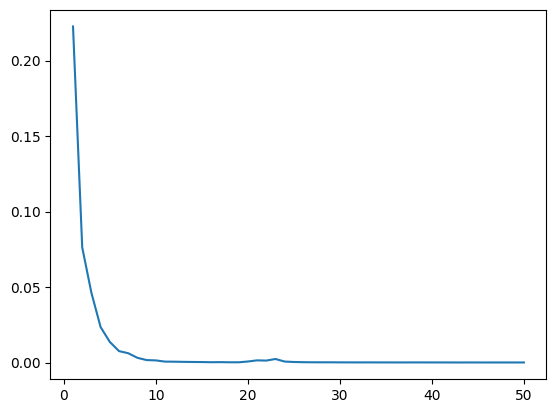

In [219]:
plt.plot(np.arange(1, n_epochs + 1), epoch_loss_values)
plt.show()

In [52]:
true_labels, predictions = make_predictions(model, df_test, batch_size=batch_size, threshold=0.5)

prediction: 1
truth: 1
message contains: Collect your VALENTINE'S weekend to PARIS inc Flight & Hotel + £200 Prize guaranteed! Text: PARIS to No: 69101. www.rtf.sphosting.com

/////////////////////////////

prediction: 1
truth: 1
message contains: Boltblue tones for 150p Reply POLY# or MONO# eg POLY3 1. Cha Cha Slide 2. Yeah 3. Slow Jamz 6. Toxic 8. Come With Me or STOP 4 more tones txt MORE

/////////////////////////////

prediction: 1
truth: 1
message contains: Sppok up ur mob with a Halloween collection of nokia logo&pic message plus a FREE eerie tone, txt CARD SPOOK to 8007

/////////////////////////////

prediction: 1
truth: 1
message contains: Get 3 Lions England tone, reply lionm 4 mono or lionp 4 poly. 4 more go 2 www.ringtones.co.uk, the original n best. Tones 3GBP network operator rates apply

/////////////////////////////

prediction: 1
truth: 1
message contains: Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc a

In [222]:
print(classification_report(true_labels, predictions))
print(accuracy_score(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        26
           1       0.92      0.92      0.92        24

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50

0.92


In [53]:
true_labels, predictions = make_predictions(model, df_train, batch_size=batch_size, threshold=0.5)

prediction: 1
truth: 1
message contains: UR awarded a City Break and could WIN a £200 Summer Shopping spree every WK. Txt STORE to 88039.SkilGme.TsCs087147403231Winawk!Age16+£1.50perWKsub

/////////////////////////////

prediction: 1
truth: 1
message contains: Romantic Paris. 2 nights, 2 flights from £79 Book now 4 next year. Call 08704439680Ts&Cs apply.

/////////////////////////////

prediction: 1
truth: 1
message contains: For ur chance to win a £250 wkly shopping spree TXT: SHOP to 80878. T's&C's www.txt-2-shop.com custcare 08715705022, 1x150p/wk

/////////////////////////////

prediction: 1
truth: 1
message contains: PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S. I. M. points. Call 08719899230 Identifier Code: 41685 Expires 07/11/04

/////////////////////////////

prediction: 1
truth: 1
message contains: Welcome to UK-mobile-date this msg is FREE giving you free calling to 08719839835. Future mgs billed at 150p daily. To cancel send "go stop" to 89123

/////////

In [224]:
print(classification_report(true_labels, predictions))
print(accuracy_score(true_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       375
           1       1.00      1.00      1.00       395

    accuracy                           1.00       770
   macro avg       1.00      1.00      1.00       770
weighted avg       1.00      1.00      1.00       770

1.0


#### Again 100% accuracy on training data (possible overfitting). Accuracy on test data also decreased.

#### Let's try using word2vec

In [54]:
df_sentences = df_train['Message_filtered'].tolist() + df_test['Message_filtered'].tolist()

n_dim = 300

lang_model = Word2Vec(sentences=df_sentences,
                      vector_size=n_dim,
                      min_count=5,
                      window=5)

In [55]:
lang_model.train(df_sentences, 
                 total_examples=lang_model.corpus_count,
                 epochs=50)

(394050, 608800)

In [56]:
W2V_IDX = lang_model.wv.key_to_index.copy()

In [253]:
lang_model.wv.most_similar('think')

[('secret', 0.9530713558197021),
 ('looking', 0.9496530890464783),
 ('make', 0.9391587376594543),
 ('reveal', 0.9384656548500061),
 ('admirer', 0.9317489266395569),
 ('u-find', 0.9255936741828918),
 ('special-call', 0.9145146608352661),
 ('special', 0.7811849117279053),
 ('second', 0.7052447199821472),
 ('wil', 0.6782258749008179)]

In [254]:
lang_model.wv.most_similar('true')

[('buy', 0.9275670647621155),
 ('angry', 0.9085258841514587),
 ('job', 0.9039337038993835),
 ('wen', 0.88893061876297),
 ('care', 0.8790623545646667),
 ('okay', 0.8705726861953735),
 ('hope', 0.869246780872345),
 ('really', 0.8679308891296387),
 ('hey', 0.8663870692253113),
 ('believe', 0.8633885383605957)]

In [255]:
lang_model.wv.most_similar('link')

[('click', 0.9267894625663757),
 ('replying', 0.8642755746841431),
 ('next', 0.8542582988739014),
 ('crazy', 0.8459959030151367),
 ('themob', 0.8373398184776306),
 ('polys', 0.8293896913528442),
 ('wap', 0.8281345963478088),
 ('sound', 0.8209269046783447),
 ('sport', 0.8155875205993652),
 ('flag', 0.8134487271308899)]

In [256]:
lang_model.wv.most_similar('free')

[('mobile', 0.8753393888473511),
 ('colour', 0.8611534833908081),
 ('phone', 0.8405758142471313),
 ('entitled', 0.8387892246246338),
 ('update', 0.8387447595596313),
 ('latest', 0.8236472010612488),
 ('charge', 0.8229407668113708),
 ('flag', 0.8173990249633789),
 ('activate', 0.8161972761154175),
 ('unlimited', 0.8044788241386414)]

In [57]:
w2v_vectors = lang_model.wv
print(w2v_vectors)

KeyedVectors<vector_size=300, 581 keys>


In [58]:
E_W2V = np.array([w2v_vectors[w] for w in w2v_vectors.key_to_index.keys()])
E_W2V.shape

(581, 300)

In [59]:
class Word2VecLSTM(nn.Module):
    
    #constructor for initializing the model
    def __init__(self, embedding_matrix, hidden_size):
        super(self.__class__, self).__init__()
        #get the vocabulary size and embedding size from the given embedding matrix
        self.vocab_size, self.embedding_size = embedding_matrix.shape
        
        #adding word embedding layer from word2vec
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)
        self.embedding.weight = torch.nn.Parameter(embedding_matrix)
        self.embedding.weight.requires_grad = False
        
        #define the hidden size for LSTM
        self.hidden_size = hidden_size
        
        #define a bidirectional LSTM layer
        self.lstm = nn.LSTM(input_size=self.embedding_size, 
                            hidden_size=self.hidden_size, 
                            num_layers=1, 
                            batch_first=True,
                            bidirectional=True)
        #define a linear layer for the output
        #output size is set to 1 for binary classification
        self.linear = nn.Linear(2 * self.hidden_size, 1)     
        #sigmoid activation for binary classification
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, sequences_lengths):
        #embedding the text sequence
        embedding = self.embedding(x)
        
        #packing the padded sequence for more efficient computation
        pack = torch.nn.utils.rnn.pack_padded_sequence(
            embedding, sequences_lengths, 
            batch_first=True, enforce_sorted=False
        )
        
        #pass the packed sequence through the bidirectional LSTM layer
        packed_out, _ = self.lstm(pack)
        #unpack the packed sequence
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(
            packed_out, batch_first=True
        )
        #get the last hidden state
        out_fwd = out[range(len(out)), sequences_lengths - 1, :self.hidden_size]
        #get the first hidden state
        out_rev = out[:, 0, self.hidden_size:]
        #concatenate the hidden states
        out_red = torch.cat((out_fwd, out_rev), 1)
        #pass the hidden states through the linear layer
        from_linear = self.linear(out_red)
        output = self.sigmoid(from_linear)
        return output

In [60]:
model = Word2VecLSTM(
    embedding_matrix=torch.nn.Parameter(torch.from_numpy(E_W2V).float()).to(device), hidden_size=100
)
model.to(device)

Word2VecLSTM(
  (embedding): Embedding(581, 300)
  (lstm): LSTM(300, 100, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [61]:
epoch_loss_values = []
step_loss_values = []

In [62]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [63]:
df_train['Message_filtered_w2v'] = df_train['Message_modified'].apply(lambda u: sequence_cleaner(u, W2V_IDX.keys()))
df_test['Message_filtered_w2v'] = df_test['Message_modified'].apply(lambda u: sequence_cleaner(u, W2V_IDX.keys()))

/var/folders/4b/b3hx73cj4fzcm29xwvlsn2j80000gn/T/ipykernel_78591/708393883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Message_filtered_w2v'] = df_test['Message_modified'].apply(lambda u: sequence_cleaner(u, W2V_IDX.keys()))


In [72]:
df_train = df_train[df_train['Message_filtered_w2v'].apply(lambda u: len(u)) != 0].reset_index(drop=True)

In [73]:
df_test = df_test[df_test['Message_filtered_w2v'].apply(lambda u: len(u)) != 0].reset_index(drop=True)

In [74]:
batch_size = 50
n_epochs = 50
n_train = df_train.shape[0]

In [75]:
n_iters = n_train // batch_size
n_tab = str(len(str(n_epochs)))

In [76]:
residue = n_train - n_iters * batch_size

for epoch in range(n_epochs):
    epoch_loss = 0 
    
    df_train_c = df_train.copy().sample(n_train).reset_index(drop=True)
    
    for step in range(n_iters):

        optimizer.zero_grad()
        idx = np.arange(0, batch_size, 1) + batch_size * step
        current_batch = df_train_c.iloc[idx]

        batch_idx, seq_lengths = vectorize(current_batch['Message_filtered_w2v'].tolist(), W2V_IDX)
        seq_lengths = np.array(seq_lengths)
        if any(length <= 0 for length in seq_lengths):
            continue 
        batch_idx = torch.tensor(batch_idx, dtype=torch.int64).to(device)
       
        
        y_true = current_batch['Category'].tolist() 
        y_true = torch.tensor(y_true, dtype=torch.float).to(device)

        y_pred = model(batch_idx, seq_lengths)
        
        loss = loss_function(y_pred.squeeze(), y_true)
        
        step_loss_values.append(loss)

        epoch_loss += loss.item() / (n_iters + 1)
        loss.backward()
        optimizer.step()
        
    if residue > 0:
        
        optimizer.zero_grad()
        
        idx = np.arange(batch_size * step, n_train, 1)
        current_batch = df_train_c.iloc[idx]

        batch_idx, seq_lengths = vectorize(current_batch['Message_filtered_w2v'].tolist(), W2V_IDX)
        seq_lengths = np.array(seq_lengths)
        batch_idx = torch.tensor(batch_idx, dtype=torch.int64).to(device)
        
        y_true = current_batch['Category'].tolist() 
        y_true = torch.tensor(y_true, dtype=torch.float).to(device)

        y_pred = model(batch_idx, seq_lengths)
        
        loss = loss_function(y_pred.squeeze(), y_true)
        
        step_loss_values.append(loss)

        epoch_loss += loss.item() / (n_iters + 1)
        loss.backward()
        optimizer.step()        
    
    epoch_loss_values.append(epoch_loss)
            
    print(('epoch {:' + n_tab + '}: epoch_loss: {}').format(epoch+1, epoch_loss)) 

epoch  1: epoch_loss: 0.16392453560339548
epoch  2: epoch_loss: 0.13794622141202648
epoch  3: epoch_loss: 0.157278657491718
epoch  4: epoch_loss: 0.11623264742749077
epoch  5: epoch_loss: 0.0947141486353108
epoch  6: epoch_loss: 0.08278140921278723
epoch  7: epoch_loss: 0.060656624047883904
epoch  8: epoch_loss: 0.05027147349236266
epoch  9: epoch_loss: 0.03533397026226989
epoch 10: epoch_loss: 0.027531716373882124
epoch 11: epoch_loss: 0.017755338547950878
epoch 12: epoch_loss: 0.011251315000533526
epoch 13: epoch_loss: 0.007408048101102137
epoch 14: epoch_loss: 0.005832295257797731
epoch 15: epoch_loss: 0.004445710564531119
epoch 16: epoch_loss: 0.004526120603259186
epoch 17: epoch_loss: 0.004189843937638216
epoch 18: epoch_loss: 0.00387705396860838
epoch 19: epoch_loss: 0.0038455761859950144
epoch 20: epoch_loss: 0.003701476924886394
epoch 21: epoch_loss: 0.004241120508855342
epoch 22: epoch_loss: 0.003476053406432454
epoch 23: epoch_loss: 0.003339854827832563
epoch 24: epoch_loss: 

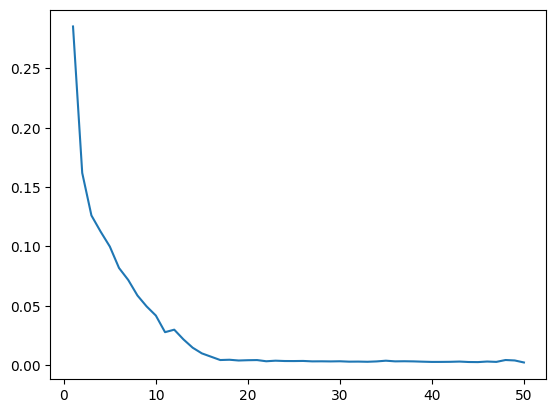

In [273]:
plt.plot(np.arange(1, n_epochs + 1), epoch_loss_values)
plt.show()

In [77]:
def make_predictions_w2v(model, df_test, batch_size, threshold, prints_b = True): 
    global W2V_IDX
    
    n_prints = 0
    predictions = []
    true_labels = []
    test_batches = split(df_test, batch_size)
    
    for batch in test_batches:
        batch_ix, seq_lengths = vectorize(batch['Message_filtered'].tolist(), W2V_IDX)
        seq_lengths = np.array(seq_lengths)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

        y_true = batch['Category'].tolist()

        y_pred = model(batch_ix, seq_lengths).cpu().detach().squeeze().numpy()
        y_pred = [int(pred.item() > threshold) for pred in y_pred]
        
        predictions.extend(y_pred)
        true_labels.extend(y_true)
        
        if prints_b:
            for true, pred, document in zip(y_true, y_pred, batch['Message']):
                if true == 1.0 and n_prints < 10:
                    print("prediction: {}".format(pred))
                    print("truth: {}".format(true))
                    print("message contains: {}".format(document))
                    print("\n" + "/////////////////////////////" + "\n")
                    n_prints += 1
        
    return true_labels, predictions

In [78]:
true_labels, predictions = make_predictions_w2v(model, df_test, batch_size=batch_size, threshold=0.5)

prediction: 1
truth: 1
message contains: Collect your VALENTINE'S weekend to PARIS inc Flight & Hotel + £200 Prize guaranteed! Text: PARIS to No: 69101. www.rtf.sphosting.com

/////////////////////////////

prediction: 1
truth: 1
message contains: Boltblue tones for 150p Reply POLY# or MONO# eg POLY3 1. Cha Cha Slide 2. Yeah 3. Slow Jamz 6. Toxic 8. Come With Me or STOP 4 more tones txt MORE

/////////////////////////////

prediction: 1
truth: 1
message contains: Sppok up ur mob with a Halloween collection of nokia logo&pic message plus a FREE eerie tone, txt CARD SPOOK to 8007

/////////////////////////////

prediction: 1
truth: 1
message contains: Get 3 Lions England tone, reply lionm 4 mono or lionp 4 poly. 4 more go 2 www.ringtones.co.uk, the original n best. Tones 3GBP network operator rates apply

/////////////////////////////

prediction: 1
truth: 1
message contains: Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc a

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [278]:
print(classification_report(true_labels, predictions))
print(accuracy_score(true_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      0.61      0.75        33
           1       0.75      1.00      0.86        39

    accuracy                           0.82        72
   macro avg       0.88      0.80      0.81        72
weighted avg       0.86      0.82      0.81        72

0.8194444444444444


In [79]:
true_labels, predictions = make_predictions_w2v(model, df_train, batch_size=batch_size, threshold=0.5)

prediction: 1
truth: 1
message contains: UR awarded a City Break and could WIN a £200 Summer Shopping spree every WK. Txt STORE to 88039.SkilGme.TsCs087147403231Winawk!Age16+£1.50perWKsub

/////////////////////////////

prediction: 1
truth: 1
message contains: Romantic Paris. 2 nights, 2 flights from £79 Book now 4 next year. Call 08704439680Ts&Cs apply.

/////////////////////////////

prediction: 1
truth: 1
message contains: For ur chance to win a £250 wkly shopping spree TXT: SHOP to 80878. T's&C's www.txt-2-shop.com custcare 08715705022, 1x150p/wk

/////////////////////////////

prediction: 1
truth: 1
message contains: PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S. I. M. points. Call 08719899230 Identifier Code: 41685 Expires 07/11/04

/////////////////////////////

prediction: 1
truth: 1
message contains: Welcome to UK-mobile-date this msg is FREE giving you free calling to 08719839835. Future mgs billed at 150p daily. To cancel send "go stop" to 89123

/////////

In [280]:
print(classification_report(true_labels, predictions))
print(accuracy_score(true_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      0.61      0.76       657
           1       0.74      1.00      0.85       702

    accuracy                           0.81      1359
   macro avg       0.87      0.81      0.80      1359
weighted avg       0.86      0.81      0.81      1359

0.8138337012509198


#### Our custom model performed better on the test data. But it had overfitting problem with train data.

#### Existing model had no overfitting. But it had lower accuracy for the test data.

#### As a conclusion, we can say that it is better to take existing tools and adjust them to suit yourself. It's faster, therefore "cheaper"